In [1]:
import pandas as pd
import numpy as np
import requests
import time
import re
import json
import time
import random

import spotipy
import tweepy

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from collections import defaultdict
from collections import deque
from fake_useragent import UserAgent

%matplotlib inline

In [2]:
test = pd.read_csv("helper/test.csv")
train = pd.read_csv("helper/train.csv")
artists = pd.read_csv("helper/artists.csv")
profiles = pd.read_csv("helper/profiles.csv")

median_age = profiles.age.median()
profiles.age = [median_age if (age > 110) or (age < 0) else age for age in profiles.age]

In [3]:
n_user_plays = {}
for user in train.groupby('user') :
    n_user_plays[user[0]] = len(user[1])

In [4]:
%time
user_medians = {}
for user in train.groupby('user') :
    user_medians[user[0]] = user[1]['plays'].median()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [5]:
GLOBAL_USER_MEDIAN = np.median(user_medians.values())
print GLOBAL_USER_MEDIAN

106.0


In [6]:
%time
artist_medians = {}
for artist in train.groupby('artist') :
    artist_medians[artist[0]] = artist[1]['plays'].median()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [7]:
GLOBAL_ARTIST_MEDIAN = np.median(artist_medians.values())
print GLOBAL_ARTIST_MEDIAN 

113.0


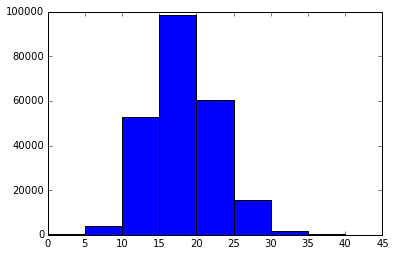

In [8]:
plt.hist(n_user_plays.values(), bins=range(0,50,5));

In [9]:
n_artist_plays = {}
for artist in train.groupby('artist') :
    n_artist_plays[artist[0]] = len(artist[1])

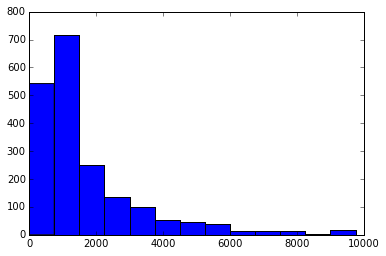

In [10]:
plt.hist(n_artist_plays.values(), bins=range(0,10000,750));

In [11]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user')
    ldfa=ldf.groupby('artist')
    user_median=ldfu.plays.median()
    user_artist_count=ldfu.artist.count()
    artist_median=ldfa.plays.median()
    artist_user_count=ldfa.user.count()
    
    nldf=ldf.copy()
    nldf.set_index(['artist'], inplace=True)
    nldf['artist_median']=artist_median
    nldf['artist_user_count']=artist_user_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user'], inplace=True)
    nldf['user_median']=user_median
    nldf['user_artist_count']=user_artist_count
    nldf.reset_index(inplace=True)
    return nldf

In [12]:
big_train=recompute_frame(train)
print "Number of Play Counts", big_train.shape[0]
print "Number of Users", big_train.user.unique().shape[0]
print "Number of Artists", big_train.artist.unique().shape[0]

Number of Play Counts 4154804
Number of Users 233286
Number of Artists 2000


In [13]:
unique_users_count = []
unique_artists_count = []
for frac in np.arange(0,0.1,0.01) :
    small_train = big_train.sample(frac=frac, replace=False)
    unique_users_count.append(small_train.user.unique().shape[0])
    unique_artists_count.append(small_train.artist.unique().shape[0])

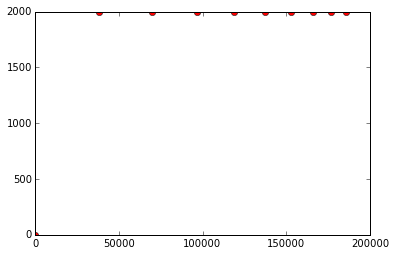

In [14]:
plt.plot(unique_users_count, unique_artists_count, 'ro');

In [15]:
# We lose a lot of unique users if we go to 1% 
# but we still maintain 100% of artists, so we
# will sample 1% multiple times and reevaluate
# if we get bad results later on. I believe that
# is possible to drop a lot of unique users 
# because they have less identifying characteristics
# and with several tens of thousands of users
# we can still get a good model.

In [16]:
small_train = big_train.sample(frac=0.05, replace=False)
small_train = recompute_frame(small_train)
small_train.to_csv("small_train.csv", index=False)
print "Number of Play Counts", small_train.shape[0]
print "Number of Users", small_train.user.unique().shape[0]
print "Number of Artists", small_train.artist.unique().shape[0]

Number of Play Counts 207740
Number of Users 137232
Number of Artists 2000


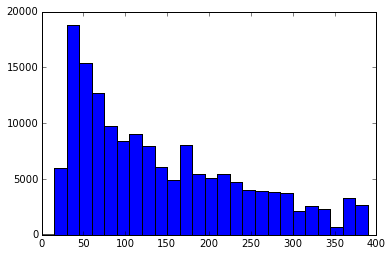

In [17]:
plt.hist(small_train.artist_user_count, bins=range(0,400,15));

In [18]:
trainlist=[]
testlist=[]
validatelist=[]
take=5
for k, v in small_train.groupby('artist'):
    if np.mean(v.artist_user_count) > 10:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(197740, 7) (6000, 7) (4000, 7)


In [19]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['user', 'artist','plays']]
testdf=testdf[['user', 'artist','plays']]

In [20]:
artistdf = pd.read_pickle('helper/artist_df.pkl')
artistdf = artistdf.rename(columns={'artist_id' : 'artist'})
artistdf.shape

(2000, 201)

In [21]:
import geonamescache

gc = geonamescache.GeonamesCache()
countries = gc.get_countries_by_names()
continents = gc.get_continents()

country_list = defaultdict(int)
for country in profiles['country'] :
    country_list[country] += 1
    
for country in country_list.keys() :
    if country not in countries.keys() :
        print country

Libyan Arab Jamahiriya
Cocos (Keeling) Islands
Russian Federation
Virgin Islands, British
Cote D'Ivoire
Viet Nam
Syrian Arab Republic
Congo, the Democratic Republic of the
Iran, Islamic Republic of
Falkland Islands (Malvinas)
Micronesia, Federated States of
Timor-Leste
Virgin Islands, U.s.
Korea, Republic of
Lao People's Democratic Republic
Tanzania, United Republic of
Holy See (Vatican City State)
Brunei Darussalam
Korea, Democratic People's Republic of
Congo
Heard Island and Mcdonald Islands
Palestinian Territory, Occupied


In [22]:
def replace_country_name(df, oldname, newname) :
    df['country'] = [newname if country_name == oldname else country_name for country_name in df['country']]
    return df

In [23]:
profiles = replace_country_name(profiles, 'Libyan Arab Jamahiriya', 'Libya')
profiles = replace_country_name(profiles, "Cocos (Keeling) Islands", "Cocos Islands")
profiles = replace_country_name(profiles, 'Russian Federation', 'Russia')
profiles = replace_country_name(profiles, 'Virgin Islands, British', 'British Virgin Islands')
profiles = replace_country_name(profiles, "Cote D'Ivoire", "Ivory Coast")
profiles = replace_country_name(profiles, "Viet Nam", "Vietnam")
profiles = replace_country_name(profiles, "Syrian Arab Republic", "Syria")
profiles = replace_country_name(profiles, "Congo, the Democratic Republic of the", "Congo")
profiles = replace_country_name(profiles, "Iran, Islamic Republic of", "Iran")
profiles = replace_country_name(profiles, "Falkland Islands (Malvinas)", "Falkland Islands")
profiles = replace_country_name(profiles, "Micronesia, Federated States of", "Micronesia")
profiles = replace_country_name(profiles, "Timor-Leste", "East Timor")
profiles = replace_country_name(profiles, "Virgin Islands, U.s.", "U.S. Virgin Islands")
profiles = replace_country_name(profiles, "Korea, Republic of", "South Korea")
profiles = replace_country_name(profiles, "Lao People's Democratic Republic", "Laos") 
profiles = replace_country_name(profiles, "Tanzania, United Republic of", "Tanzania")
profiles = replace_country_name(profiles, "Holy See (Vatican City State)", "Vatican")
profiles = replace_country_name(profiles, "Heard Island and Mcdonald Islands", "Heard Island and McDonald Islands")
profiles = replace_country_name(profiles, "Brunei Darussalam", "Brunei")
profiles = replace_country_name(profiles, "Korea, Democratic People's Republic of", "North Korea")
profiles = replace_country_name(profiles, "Congo", "Democratic Republic of the Congo")
profiles = replace_country_name(profiles, "Palestinian Territory, Occupied", "Israel")

In [24]:
for continent in continents.keys() :
    profiles["cont_"+continent] = [1 if countries[user_country]['continentcode'] == continent else 0 for user_country in profiles['country']]

In [25]:
for country in country_list.keys() :
    if country_list[country] > 2000 :
        profiles["country_"+country.lower().replace(" ","_")] = [1 if user_country == country else 0 for user_country in profiles['country']]

In [26]:
profiles['gender'] = [1 if sex == 'm' else 0 for sex in profiles['sex']]
profiles = profiles.drop(['country', 'sex'], axis=1)
profiles.head()

,user,age,cont_AF,cont_NA,cont_OC,cont_AN,cont_AS,cont_EU,cont_SA,country_canada,...,country_australia,country_belgium,country_switzerland,country_portugal,country_italy,country_germany,country_poland,country_mexico,country_united_kingdom,gender
0,fa40b43298ba3f8aa52e8e8863faf2e2171e0b5d,25,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5909125332c108365a26ccf0ee62636eee08215c,29,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,d1867cbda35e0d48e9a8390d9f5e079c9d99ea96,30,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,63268cce0d68127729890c1691f62d5be5abd87c,21,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,02871cd952d607ba69b64e2e107773012c708113,24,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
def merge_dfs(df, artistdf, userdf) :
    merged = pd.merge(df, artistdf, on='artist')
    merged = pd.merge(merged, userdf, on='user')
    for col in ['mean','median','user','artist','std','artist_user_count','user_artist_count','name'] :
        try :
            merged = merged.drop(col, axis=1)
        except :
            pass
    X = merged.drop(['plays'], axis=1)
    y = merged['plays']
    X = X.fillna(0)
    print X.shape, y.shape
    return X, y

In [28]:
def add_medians(traindf, testdf, GLOBAL_USER_MEDIAN, GLOBAL_ARTIST_MEDIAN) :
    user_medians = defaultdict(lambda: GLOBAL_USER_MEDIAN)
    artist_medians = defaultdict(lambda: GLOBAL_ARTIST_MEDIAN)

    ldfu=traindf.groupby('user')
    ldfa=traindf.groupby('artist')

    for u in ldfu :
        user_medians[u[0]] = u[1]['plays'].median()
    for a in ldfa : 
        artist_medians[a[0]] = a[1]['plays'].median()

    testdf['user_median'] = [user_medians[user] for user in testdf['user']]
    testdf['artist_median'] = [artist_medians[artist] for artist in testdf['artist']]
    
    return testdf

In [29]:
X_train, y_train = merge_dfs(traindf, artistdf, profiles)

(197740, 229) (197740,)


In [30]:
validatedf = add_medians(traindf, validatedf, GLOBAL_USER_MEDIAN, GLOBAL_ARTIST_MEDIAN)
X_valid, y_valid = merge_dfs(validatedf, artistdf, profiles)

(6000, 229) (6000,)


In [31]:
testdf = add_medians(traindf, testdf, GLOBAL_USER_MEDIAN, GLOBAL_ARTIST_MEDIAN)
X_test, y_test = merge_dfs(testdf, artistdf, profiles)

(4000, 229) (4000,)


In [ ]:
%time
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)
y_lm_pred = lm.predict(X_test)

In [33]:
def MAE(arr1, arr2) :
    if len(arr1) == len(arr2) :
        plt.hist(np.abs(arr1-arr2))
        print 1.0/len(arr1) * np.sum(np.abs(arr1 - arr2))
    else :
        print "Array not the same length"

172.660002464


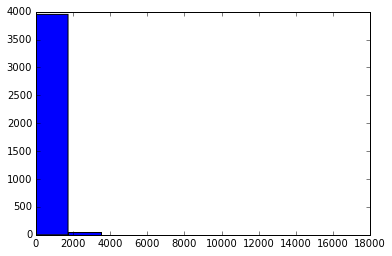

In [38]:
MAE(np.abs(y_lm_pred), y_test)

In [2]:
import pandas as pd
user_median = pd.read_csv("helper/user_median.csv")

IOError: File helper/user_median.csv does not exist